# LAB 7 : Image Classification using Convolutional Neural Networks 

Name : Joshitha, Vaishnavi

Roll Number : 180020009, 180020039
  

#**Problem 1** : Demonstrate Image Classification using CNNs on MNIST Fashion Dataset 

Steps : 

1. Download the MNIST fashion dataset (Available on Kaggle), there are 60,000 examples in the training set spanning all the 10 classes, Take a subset of this (around 1000 examples from each class) and make sure to have a balanced dataset, follow the same procedure for the test set (Maintain a 90:10 split between Train and Test set). Create a proper analysis table of the dataset using histogram plots.

2. Design a convolutional neural network using appropriate layers (Feel free to experiment around this) using any of the Frameworks (Keras/Pytorch/Tensorflow).

3. Consider suitable evaluation metrics and use plots as well as confusion matrix to highlight the accuracy, precision, recall and F1 score on both train and test set.

4. If you observe degradation in test accuracy make suitable changes to the network to encounter the problem.

**Note** : 
  1. There are no restrications on the usage Libraries as well as Frameworks.
  
  2. In this Lab, the emphasis will be more on your presentation rather than the solution, so make sure to include appropriate plots and tables to highlight your observations.

  3. You can also perform the experiment on a different dataset of Image classification as well but make sure to use balanced data.

##Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming : 
  Please write a program to demonstrate the same

##Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/MyDrive/mnist_fashion.zip' mnist

In [ ]:
!unzip /content/mnist

Archive:  /content/mnist
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from matplotlib import pyplot as plt

In [ ]:
train = pd.read_csv("/content/fashion-mnist_train.csv")
test = pd.read_csv("/content/fashion-mnist_test.csv")
print("Loaded the fashion mnist datasets")
print("train", train.shape)
print("test", test.shape)

groups = train.groupby('label')
train = groups.apply(lambda x:x.sample(frac=1)[:1000]) # shuffled before get values
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
print("train", train.shape)

groups = test.groupby('label')
test = groups.apply(lambda x:x.sample(frac=1)[:100]) # shuffled before get values
test = test.sample(frac=1, random_state=42).reset_index(drop=True)
print("test", test.shape)

labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

Loaded the fashion mnist datasets
train (60000, 785)
test (10000, 785)
train (10000, 785)
test (1000, 785)


In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,55,131,67,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,159,215,109,0,0,0,0


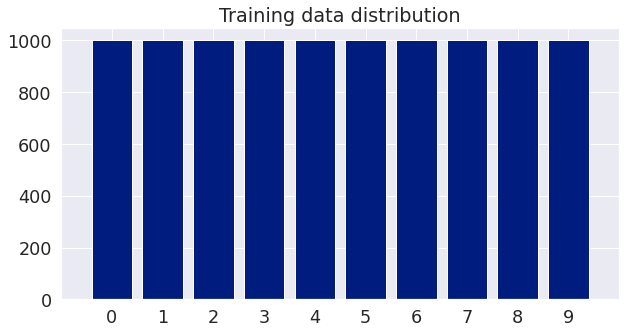

In [ ]:
import matplotlib.pyplot as plt

counts = np.bincount(train['label'])

plt.style.use('seaborn-dark-palette')

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Training data distribution')

plt.show()


evenly distributed

In [ ]:
Y_train = to_categorical(train["label"], num_classes=10)

Y_test  = to_categorical(test["label"], num_classes=10)


print("X data needs to be reformed and normalized")
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_train = X_train.values.reshape(-1, 28, 28)

X_test = test.drop(labels = ["label"],axis = 1)
X_test = X_test / 255.0
X_test = X_test.values.reshape(-1, 28, 28)

print(X_train.shape)
print(X_test.shape)



X data needs to be reformed and normalized
(10000, 28, 28)
(1000, 28, 28)


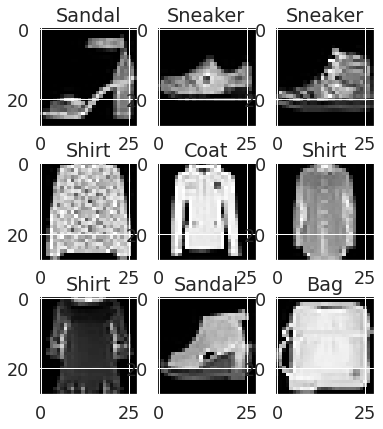

In [ ]:
plt.figure(figsize=(6,7))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 +i)
    # plot raw pixel data
    plt.title(labels[int(Y_test[i].argmax())])
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()



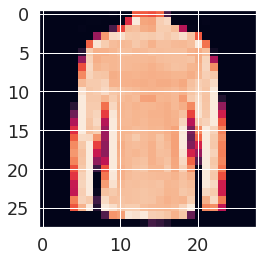

In [ ]:
plt.imshow(X_train[0])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator( width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            ## x_batch.shape = (bsize,28,28,1)
            ## where bsize = np.min(batch_size,x.shape[0])
            yield ([x_batch, y_batch])

In [ ]:
shift_fraction = 0.1

x = X_test.reshape(-1, 28, 28,1)
y = Y_test

x_tra, y_tra = [],[]
count = 0

for generator in train_generator(x, y, 1000, shift_fraction):
  x_tra, y_tra = generator
  count += 1
  
  if count > 0:
    break

        
print(x_tra.shape,y_tra.shape)

(1000, 28, 28, 1) (1000, 10)


In [ ]:
x_tra = x_tra.reshape(-1, 28, 28)

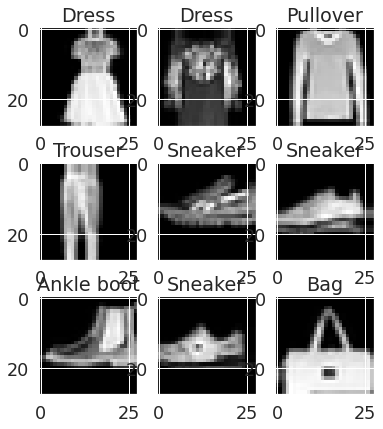

In [ ]:
plt.figure(figsize=(6,7))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 +i)
    # plot raw pixel data
    plt.title(labels[int(y_tra[i].argmax())])
    plt.imshow(x_tra[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_classification_report(preds, y_test):

    # classification report
    print(classification_report(y_test, preds))
    df = pd.DataFrame(classification_report(y_test, preds,output_dict=True)).transpose()
    fig, ax = plt.subplots(figsize=(8,8)) 

    # color map
    cmap='Blues'
    # cmap = sn.diverging_palette(0, 230, 90, 60, as_cmap=True)

    cm = confusion_matrix(y_test, preds, labels=list(set(y_test)))
    # display(cm)
    df_cm = pd.DataFrame(cm, list(set(y_test)), list(set(y_test)))
    # display(df_cm)
    sn.set(font_scale=1.6)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='.4g', ax=ax, square=True)
    plt.show()
    return df


##Model - 1 (simple FFNN)

In [ ]:
model1 = Sequential()
model1.add(Flatten())
model1.add(Dense(512, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(10, activation="softmax"))
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
input_shape = X_train.shape  
model1.build(input_shape) 
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (10000, 784)              0         
                                                                 
 dense_4 (Dense)             (10000, 512)              401920    
                                                                 
 dropout_2 (Dropout)         (10000, 512)              0         
                                                                 
 dense_5 (Dense)             (10000, 10)               5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model1.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test), shuffle=True)

Epoch 1/30
313/313 [==============================] - 1s 4ms/step - loss: 0.4189 - accuracy: 0.8462 - val_loss: 0.4657 - val_accuracy: 0.8350
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: 0.3947 - accuracy: 0.8575 - val_loss: 0.4547 - val_accuracy: 0.8510
Epoch 3/30
313/313 [==============================] - 1s 4ms/step - loss: 0.3751 - accuracy: 0.8629 - val_loss: 0.4518 - val_accuracy: 0.8310
Epoch 4/30
313/313 [==============================] - 1s 3ms/step - loss: 0.3481 - accuracy: 0.8730 - val_loss: 0.4163 - val_accuracy: 0.8560
Epoch 5/30
313/313 [==============================] - 1s 3ms/step - loss: 0.3413 - accuracy: 0.8733 - val_loss: 0.4468 - val_accuracy: 0.8480
Epoch 6/30
313/313 [==============================] - 1s 3ms/step - loss: 0.3225 - accuracy: 0.8818 - val_loss: 0.4450 - val_accuracy: 0.8510
Epoch 7/30
313/313 [==============================] - 1s 3ms/step - loss: 0.3177 - accuracy: 0.8824 - val_loss: 0.4499 - val_accuracy: 0.8490
Epoch 

In [ ]:
model1.save('/content/gdrive/MyDrive/model1')


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model1/assets


Train Data

              precision    recall  f1-score   support

  Ankle boot       0.97      1.00      0.98      1000
         Bag       1.00      1.00      1.00      1000
        Coat       0.89      0.91      0.90      1000
       Dress       0.97      0.96      0.96      1000
    Pullover       0.91      0.93      0.92      1000
      Sandal       1.00      0.99      1.00      1000
       Shirt       0.91      0.88      0.89      1000
     Sneaker       1.00      0.97      0.98      1000
 T-shirt/top       0.95      0.97      0.96      1000
     Trouser       1.00      1.00      1.00      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



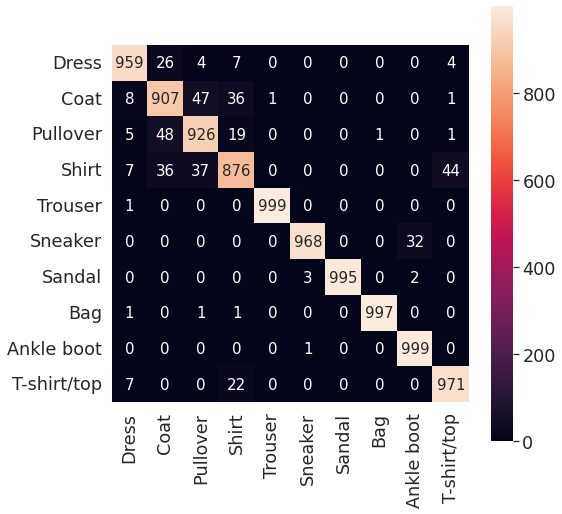

,precision,recall,f1-score,support
Ankle boot,0.967086,0.9990,0.982784,1000.0000
Bag,0.998998,0.9970,0.997998,1000.0000
Coat,0.891839,0.9070,0.899355,1000.0000
Dress,0.970648,0.9590,0.964789,1000.0000
Pullover,0.912315,0.9260,0.919107,1000.0000
Sandal,1.000000,0.9950,0.997494,1000.0000
Shirt,0.911550,0.8760,0.893422,1000.0000
Sneaker,0.995885,0.9680,0.981744,1000.0000
T-shirt/top,0.951028,0.9710,0.960910,1000.0000
Trouser,0.999000,0.9990,0.999000,1000.0000


In [ ]:
predict_x=model1.predict(X_train) 
Y_pred=np.argmax(predict_x,axis=1)
y_train = []
for x in Y_train:
  y_train.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_train = [labels[ind] for ind in y_train]
print_classification_report(Y_pred, y_train)

Test Data

              precision    recall  f1-score   support

  Ankle boot       0.87      0.97      0.92       100
         Bag       0.98      0.97      0.97       100
        Coat       0.76      0.84      0.80       100
       Dress       0.91      0.86      0.89       100
    Pullover       0.76      0.84      0.80       100
      Sandal       0.97      0.90      0.93       100
       Shirt       0.78      0.63      0.70       100
     Sneaker       0.91      0.87      0.89       100
 T-shirt/top       0.81      0.83      0.82       100
     Trouser       0.99      1.00      1.00       100

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



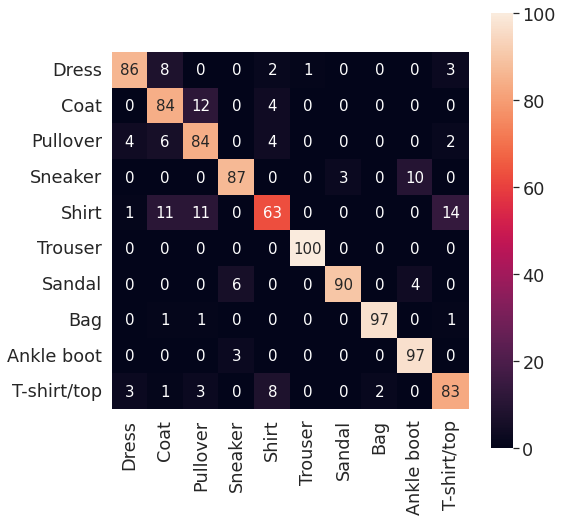

,precision,recall,f1-score,support
Ankle boot,0.873874,0.970,0.919431,100.000
Bag,0.979798,0.970,0.974874,100.000
Coat,0.756757,0.840,0.796209,100.000
Dress,0.914894,0.860,0.886598,100.000
Pullover,0.756757,0.840,0.796209,100.000
Sandal,0.967742,0.900,0.932642,100.000
Shirt,0.777778,0.630,0.696133,100.000
Sneaker,0.906250,0.870,0.887755,100.000
T-shirt/top,0.805825,0.830,0.817734,100.000
Trouser,0.990099,1.000,0.995025,100.000


In [ ]:
predict_x=model1.predict(X_test) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in Y_test:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

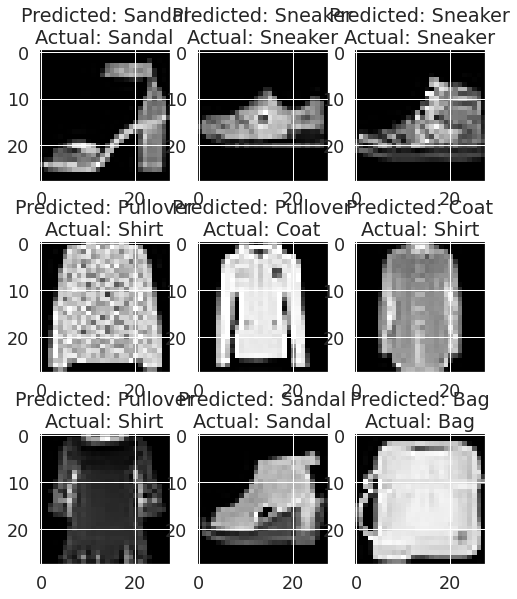

In [ ]:
_, X, _, Y = train_test_split(X_test, Y_test, test_size=10, shuffle=True)
predictions = model1.predict(X)

plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model1.predict(X_test[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = Y_test[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

traslated images

In [ ]:
x_tra.shape

(1000, 28, 28)

              precision    recall  f1-score   support

  Ankle boot       0.71      0.85      0.78       100
         Bag       0.60      0.90      0.72       100
        Coat       0.49      0.50      0.49       100
       Dress       0.69      0.59      0.64       100
    Pullover       0.44      0.35      0.39       100
      Sandal       0.85      0.69      0.76       100
       Shirt       0.36      0.33      0.34       100
     Sneaker       0.72      0.69      0.70       100
 T-shirt/top       0.73      0.57      0.64       100
     Trouser       0.59      0.68      0.63       100

    accuracy                           0.61      1000
   macro avg       0.62      0.61      0.61      1000
weighted avg       0.62      0.61      0.61      1000



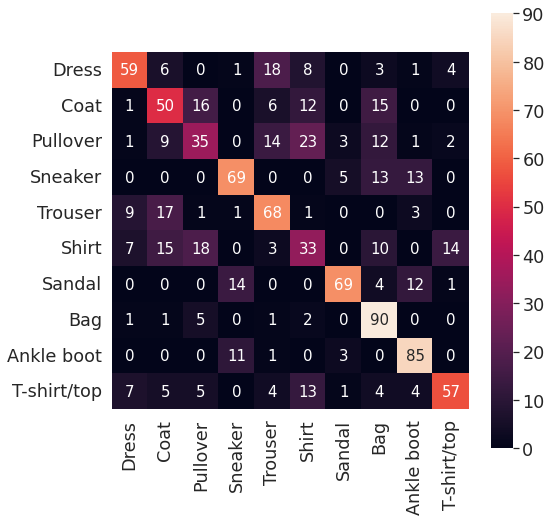

,precision,recall,f1-score,support
Ankle boot,0.714286,0.850,0.776256,100.000
Bag,0.596026,0.900,0.717131,100.000
Coat,0.485437,0.500,0.492611,100.000
Dress,0.694118,0.590,0.637838,100.000
Pullover,0.437500,0.350,0.388889,100.000
Sandal,0.851852,0.690,0.762431,100.000
Shirt,0.358696,0.330,0.343750,100.000
Sneaker,0.718750,0.690,0.704082,100.000
T-shirt/top,0.730769,0.570,0.640449,100.000
Trouser,0.591304,0.680,0.632558,100.000


In [ ]:
predict_x=model1.predict(x_tra) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in y_tra:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

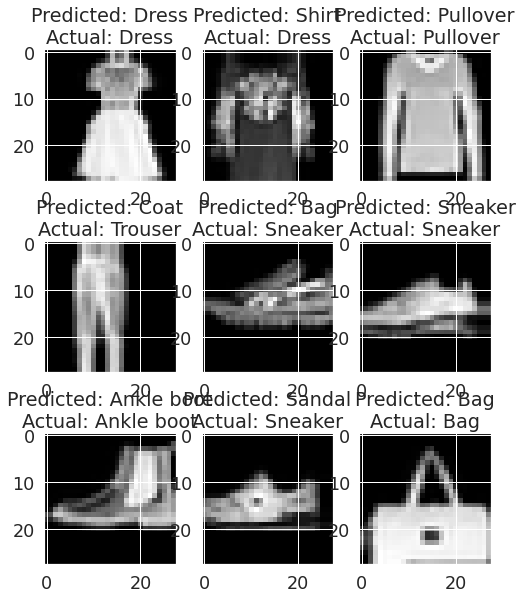

In [ ]:
plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model1.predict(x_tra[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = y_tra[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(x_tra[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

##Model - 2 (FFNN)

In [ ]:
model2 = Sequential()
model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(512, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(512, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(10, activation="softmax"))
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model2.build(input_shape) 
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (10000, 784)              0         
                                                                 
 dense_10 (Dense)            (10000, 1024)             803840    
                                                                 
 dropout_6 (Dropout)         (10000, 1024)             0         
                                                                 
 dense_11 (Dense)            (10000, 512)              524800    
                                                                 
 dropout_7 (Dropout)         (10000, 512)              0         
                                                                 
 dense_12 (Dense)            (10000, 512)              262656    
                                                                 
 dropout_8 (Dropout)         (10000, 512)             

In [ ]:
history2 = model2.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test), shuffle=True)

Epoch 1/30
313/313 [==============================] - 3s 6ms/step - loss: 0.8863 - accuracy: 0.6668 - val_loss: 0.6409 - val_accuracy: 0.7680
Epoch 2/30
313/313 [==============================] - 2s 5ms/step - loss: 0.6138 - accuracy: 0.7751 - val_loss: 0.5158 - val_accuracy: 0.8250
Epoch 3/30
313/313 [==============================] - 2s 5ms/step - loss: 0.5353 - accuracy: 0.8110 - val_loss: 0.5173 - val_accuracy: 0.8240
Epoch 4/30
313/313 [==============================] - 2s 6ms/step - loss: 0.4900 - accuracy: 0.8257 - val_loss: 0.4784 - val_accuracy: 0.8260
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 0.4788 - accuracy: 0.8286 - val_loss: 0.4702 - val_accuracy: 0.8310
Epoch 6/30
313/313 [==============================] - 2s 5ms/step - loss: 0.4558 - accuracy: 0.8361 - val_loss: 0.4622 - val_accuracy: 0.8400
Epoch 7/30
313/313 [==============================] - 2s 5ms/step - loss: 0.4337 - accuracy: 0.8419 - val_loss: 0.4643 - val_accuracy: 0.8460
Epoch 

In [ ]:
model2.save('/content/gdrive/MyDrive/model2')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model2/assets


Training Dataset 
              precision    recall  f1-score   support

  Ankle boot       0.97      0.99      0.98      1000
         Bag       1.00      0.99      0.99      1000
        Coat       0.75      0.89      0.81      1000
       Dress       0.84      0.99      0.91      1000
    Pullover       0.87      0.78      0.82      1000
      Sandal       1.00      0.98      0.99      1000
       Shirt       0.79      0.75      0.77      1000
     Sneaker       0.98      0.99      0.98      1000
 T-shirt/top       0.95      0.78      0.86      1000
     Trouser       1.00      0.97      0.98      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



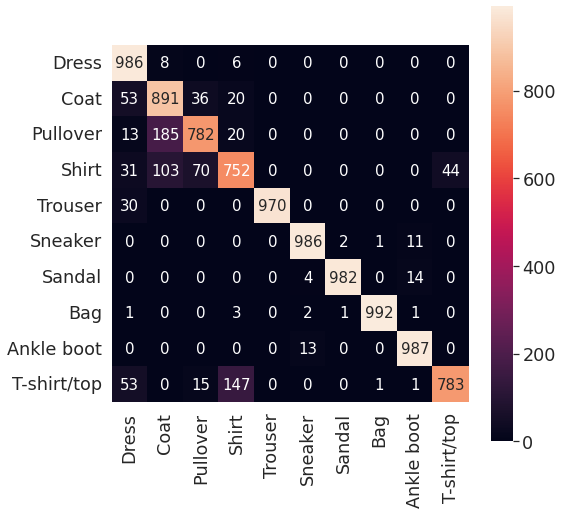

,precision,recall,f1-score,support
Ankle boot,0.973373,0.9870,0.980139,1000.0000
Bag,0.997988,0.9920,0.994985,1000.0000
Coat,0.750632,0.8910,0.814815,1000.0000
Dress,0.844901,0.9860,0.910014,1000.0000
Pullover,0.866002,0.7820,0.821860,1000.0000
Sandal,0.996954,0.9820,0.989421,1000.0000
Shirt,0.793249,0.7520,0.772074,1000.0000
Sneaker,0.981095,0.9860,0.983541,1000.0000
T-shirt/top,0.946796,0.7830,0.857143,1000.0000
Trouser,1.000000,0.9700,0.984772,1000.0000


In [ ]:
print ( "Training Dataset ")
predict_x=model2.predict(X_train) 
Y_pred=np.argmax(predict_x,axis=1)
y_train = []
for x in Y_train:
  y_train.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_train = [labels[ind] for ind in y_train]
print_classification_report(Y_pred, y_train)

Testing Dataset 
              precision    recall  f1-score   support

  Ankle boot       0.87      0.96      0.91       100
         Bag       0.99      0.98      0.98       100
        Coat       0.72      0.87      0.79       100
       Dress       0.82      0.93      0.87       100
    Pullover       0.79      0.77      0.78       100
      Sandal       0.98      0.90      0.94       100
       Shirt       0.74      0.70      0.72       100
     Sneaker       0.91      0.89      0.90       100
 T-shirt/top       0.92      0.70      0.80       100
     Trouser       0.99      0.97      0.98       100

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



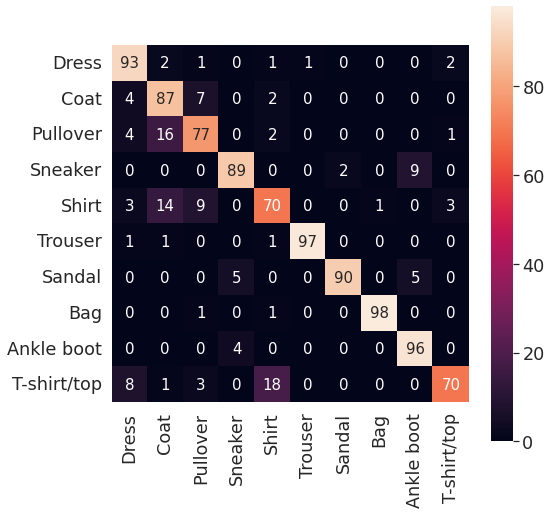

,precision,recall,f1-score,support
Ankle boot,0.872727,0.960,0.914286,100.000
Bag,0.989899,0.980,0.984925,100.000
Coat,0.719008,0.870,0.787330,100.000
Dress,0.823009,0.930,0.873239,100.000
Pullover,0.785714,0.770,0.777778,100.000
Sandal,0.978261,0.900,0.937500,100.000
Shirt,0.736842,0.700,0.717949,100.000
Sneaker,0.908163,0.890,0.898990,100.000
T-shirt/top,0.921053,0.700,0.795455,100.000
Trouser,0.989796,0.970,0.979798,100.000


In [ ]:
print ( "Testing Dataset ")

predict_x=model2.predict(X_test) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in Y_test:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

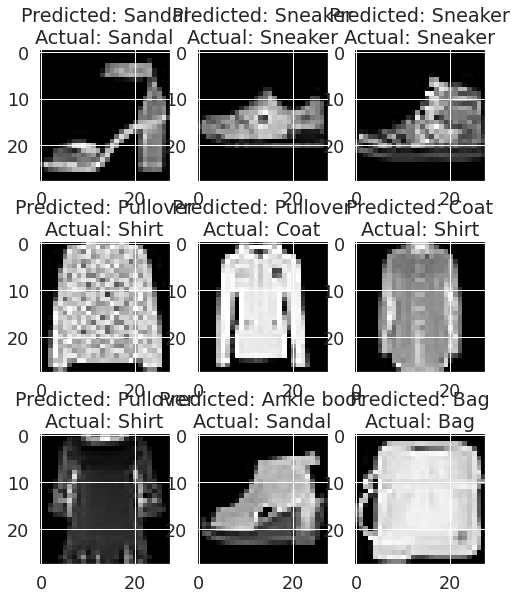

In [ ]:
_, X, _, Y = train_test_split(X_test, Y_test, test_size=10, shuffle=True)
predictions = model2.predict(X)

plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model2.predict(X_test[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = Y_test[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

traslated images

              precision    recall  f1-score   support

  Ankle boot       0.47      0.74      0.58       100
         Bag       0.64      0.90      0.75       100
        Coat       0.51      0.54      0.53       100
       Dress       0.50      0.70      0.58       100
    Pullover       0.45      0.25      0.32       100
      Sandal       0.78      0.80      0.79       100
       Shirt       0.20      0.21      0.20       100
     Sneaker       0.67      0.80      0.73       100
 T-shirt/top       0.75      0.27      0.40       100
     Trouser       0.92      0.36      0.52       100

    accuracy                           0.56      1000
   macro avg       0.59      0.56      0.54      1000
weighted avg       0.59      0.56      0.54      1000



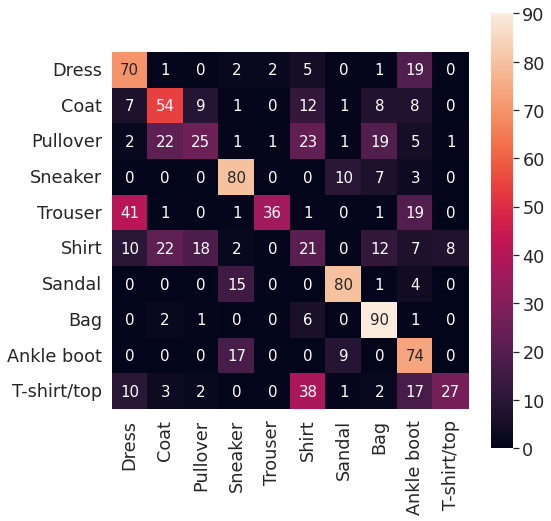

,precision,recall,f1-score,support
Ankle boot,0.471338,0.740,0.575875,100.000
Bag,0.638298,0.900,0.746888,100.000
Coat,0.514286,0.540,0.526829,100.000
Dress,0.500000,0.700,0.583333,100.000
Pullover,0.454545,0.250,0.322581,100.000
Sandal,0.784314,0.800,0.792079,100.000
Shirt,0.198113,0.210,0.203883,100.000
Sneaker,0.672269,0.800,0.730594,100.000
T-shirt/top,0.750000,0.270,0.397059,100.000
Trouser,0.923077,0.360,0.517986,100.000


In [ ]:
predict_x=model2.predict(x_tra) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in y_tra:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

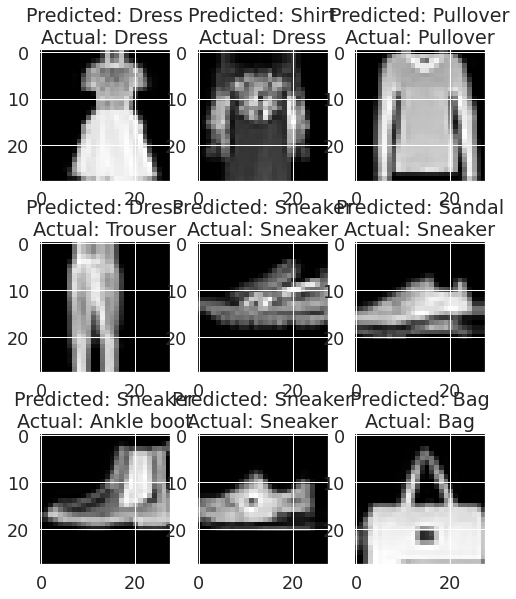

In [ ]:
plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model2.predict(x_tra[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = y_tra[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(x_tra[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

##Model - 3 (simple CNN)




In [ ]:
image_shape = (28,28,1) 
x_train = X_train.reshape(X_train.shape[0],*image_shape)
x_test = X_test.reshape(X_test.shape[0],*image_shape)

In [ ]:
model3 = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(10,activation = 'softmax')
    
])

In [ ]:
model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 5408)              0         
                                                                 
 dense_17 (Dense)            (None, 32)                173088    
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                      

In [ ]:
history3 = model3.fit(x_train, Y_train, epochs=40, batch_size=32, validation_data=(x_test, Y_test), shuffle=True)

Epoch 1/40
313/313 [==============================] - 3s 6ms/step - loss: 0.6786 - accuracy: 0.7644 - val_loss: 0.4880 - val_accuracy: 0.8280
Epoch 2/40
313/313 [==============================] - 1s 5ms/step - loss: 0.4083 - accuracy: 0.8582 - val_loss: 0.4183 - val_accuracy: 0.8680
Epoch 3/40
313/313 [==============================] - 1s 3ms/step - loss: 0.3647 - accuracy: 0.8701 - val_loss: 0.4339 - val_accuracy: 0.8470
Epoch 4/40
313/313 [==============================] - 1s 4ms/step - loss: 0.3205 - accuracy: 0.8830 - val_loss: 0.3790 - val_accuracy: 0.8780
Epoch 5/40
313/313 [==============================] - 1s 4ms/step - loss: 0.2882 - accuracy: 0.8975 - val_loss: 0.3418 - val_accuracy: 0.8840
Epoch 6/40
313/313 [==============================] - 1s 3ms/step - loss: 0.2669 - accuracy: 0.9053 - val_loss: 0.3490 - val_accuracy: 0.8760
Epoch 7/40
313/313 [==============================] - 1s 4ms/step - loss: 0.2514 - accuracy: 0.9092 - val_loss: 0.3513 - val_accuracy: 0.8880
Epoch 

In [ ]:
model3.save('/content/gdrive/MyDrive/model3')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model3/assets


Training Dataset 
              precision    recall  f1-score   support

  Ankle boot       1.00      1.00      1.00      1000
         Bag       1.00      1.00      1.00      1000
        Coat       0.99      0.99      0.99      1000
       Dress       0.99      1.00      0.99      1000
    Pullover       0.99      0.99      0.99      1000
      Sandal       1.00      1.00      1.00      1000
       Shirt       1.00      0.98      0.99      1000
     Sneaker       1.00      1.00      1.00      1000
 T-shirt/top       0.99      1.00      0.99      1000
     Trouser       1.00      0.99      0.99      1000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



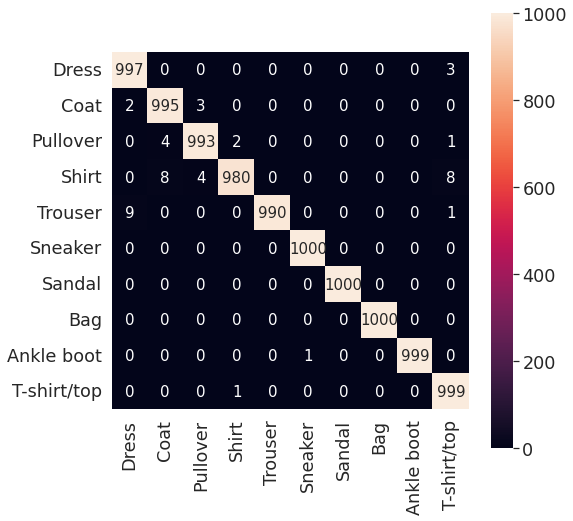

,precision,recall,f1-score,support
Ankle boot,1.000000,0.9990,0.999500,1000.0000
Bag,1.000000,1.0000,1.000000,1000.0000
Coat,0.988083,0.9950,0.991530,1000.0000
Dress,0.989087,0.9970,0.993028,1000.0000
Pullover,0.993000,0.9930,0.993000,1000.0000
Sandal,1.000000,1.0000,1.000000,1000.0000
Shirt,0.996948,0.9800,0.988401,1000.0000
Sneaker,0.999001,1.0000,0.999500,1000.0000
T-shirt/top,0.987154,0.9990,0.993042,1000.0000
Trouser,1.000000,0.9900,0.994975,1000.0000


In [ ]:
print ( "Training Dataset ")
predict_x=model3.predict(X_train) 
Y_pred=np.argmax(predict_x,axis=1)
y_train = []
for x in Y_train:
  y_train.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_train = [labels[ind] for ind in y_train]
print_classification_report(Y_pred, y_train)

Testing Dataset 
              precision    recall  f1-score   support

  Ankle boot       0.92      0.95      0.94       100
         Bag       0.97      0.96      0.96       100
        Coat       0.87      0.88      0.88       100
       Dress       0.90      0.91      0.91       100
    Pullover       0.84      0.79      0.81       100
      Sandal       0.99      0.94      0.96       100
       Shirt       0.75      0.75      0.75       100
     Sneaker       0.91      0.92      0.92       100
 T-shirt/top       0.79      0.83      0.81       100
     Trouser       0.97      0.98      0.98       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



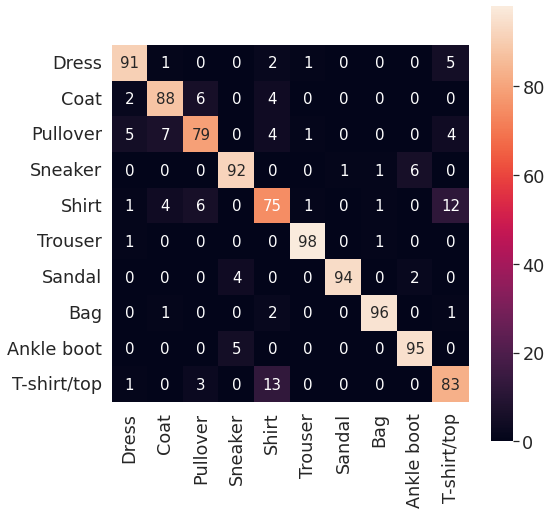

,precision,recall,f1-score,support
Ankle boot,0.922330,0.950,0.935961,100.000
Bag,0.969697,0.960,0.964824,100.000
Coat,0.871287,0.880,0.875622,100.000
Dress,0.900990,0.910,0.905473,100.000
Pullover,0.840426,0.790,0.814433,100.000
Sandal,0.989474,0.940,0.964103,100.000
Shirt,0.750000,0.750,0.750000,100.000
Sneaker,0.910891,0.920,0.915423,100.000
T-shirt/top,0.790476,0.830,0.809756,100.000
Trouser,0.970297,0.980,0.975124,100.000


In [ ]:
print ( "Testing Dataset ")

predict_x=model3.predict(X_test) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in Y_test:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

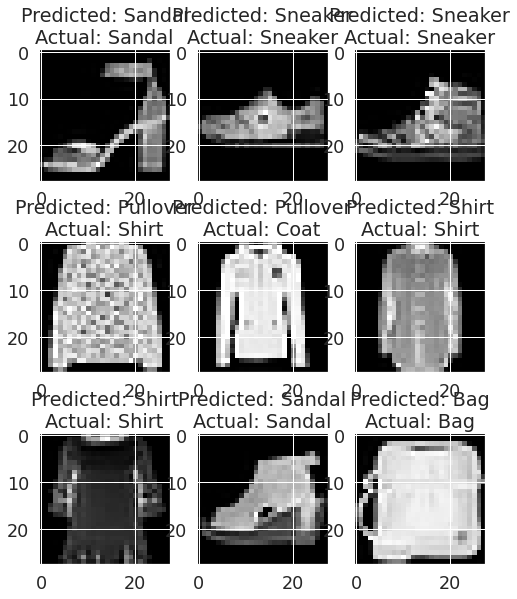

In [ ]:
_, X, _, Y = train_test_split(x_test, Y_test, test_size=10, shuffle=True)
predictions = model3.predict(X)

plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model3.predict(x_test[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = Y_test[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

traslated images

              precision    recall  f1-score   support

  Ankle boot       0.79      0.79      0.79       100
         Bag       0.74      0.86      0.79       100
        Coat       0.60      0.46      0.52       100
       Dress       0.51      0.71      0.59       100
    Pullover       0.67      0.60      0.63       100
      Sandal       0.80      0.87      0.83       100
       Shirt       0.41      0.36      0.38       100
     Sneaker       0.78      0.70      0.74       100
 T-shirt/top       0.55      0.63      0.59       100
     Trouser       0.79      0.60      0.68       100

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



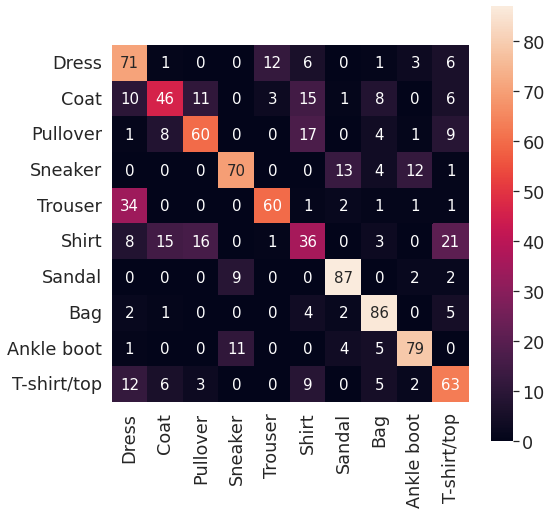

,precision,recall,f1-score,support
Ankle boot,0.790000,0.790,0.790000,100.000
Bag,0.735043,0.860,0.792627,100.000
Coat,0.597403,0.460,0.519774,100.000
Dress,0.510791,0.710,0.594142,100.000
Pullover,0.666667,0.600,0.631579,100.000
Sandal,0.798165,0.870,0.832536,100.000
Shirt,0.409091,0.360,0.382979,100.000
Sneaker,0.777778,0.700,0.736842,100.000
T-shirt/top,0.552632,0.630,0.588785,100.000
Trouser,0.789474,0.600,0.681818,100.000


In [ ]:
predict_x=model3.predict(x_tra) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in y_tra:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

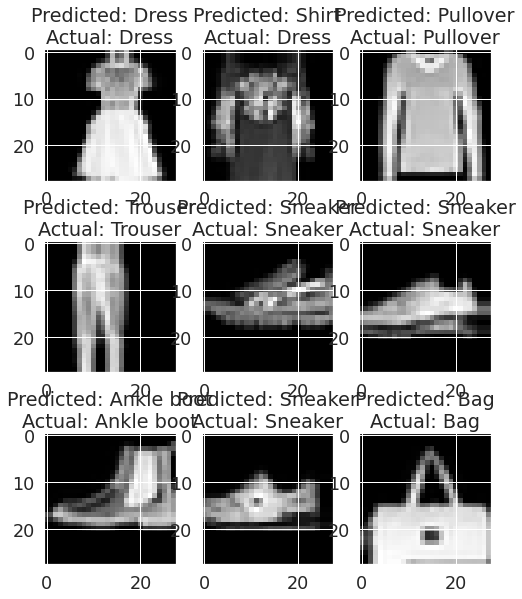

In [ ]:
plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model3.predict(x_tra[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = y_tra[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(x_tra[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

##Model - 4 (CNN with more layers + BatchNormalization)

Building a ConvNet


1) At First, we use Sequential Keras API which is just a linear stack of layers. We add one layer at a time starting from input.

2) Next We add Convolutional Layers, which are the Building blocks of ConvNets. Convolutional Layers has set of Independent Filters whose depth is equal to Input and other dimensions can be set manually. These Filters when convolved over the Input Image produce Feature Maps.

It includes some HyperParameters such as The number of filters, Dimensions of Filter (F), Stride (S), Padding(P) , Activation Function etc. which we input manually. Let the Input Volume Size be deonted by (W) ,

Then, the Output will have Dimensions given by -->

(Height, Width) = ( ( W − F + 2P ) / S ) + 1

And the Depth will be equal to Number of Filters Specified.

3) Next We add Pooling Layers, which are used for Dimensionality Reduction or DownSampling the Input. These are used where we have lot of Input Features. It reduces the amount of Parameters and Computational power required drastically, thus reducing Overfitting. These along with Convolutional layers are able to learn more Complex features of the Image.

4) We add Batch Normalization where we acheive Zero mean and Variance one. It scales down outliers and forces the network to learn features in a distributed way, not relying too much on a Particular Weight and makes the model better Generalize the Images.

5) To avoid Overfitting We add Dropout. This randomly drops some percentage of neurons, and thus the weights gets Re-Aligned. The remaining Neurons learn more features and this reduces the dependency on any one Neuron. DropOut is a Regularization Technique, which Penalizes the Parameters. Generally we set the DropOutRate between 0.2-0.5 .

6) Finally we add Flatten layer to map the input to a 1D vector. We then add Fully connected Layers after some convolutional/pooling layers. It combines all the Features of the Previous Layers.

7) Lastly, we add the Output Layer. It has units equal to the number of classes to be identified. Here, we use 'sigmoid' function if it is Binary Classification otherwise 'softmax' activation function in case of Multi-Class Classification.


In [ ]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', input_shape=(28,28,1)))
model4.add(BatchNormalization())

model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

model4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))
    
    
model4.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))
model4.add(Dense(64, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))
model4.add(Dense(10, activation='softmax'))


In [ ]:
model4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_17 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)       

In [ ]:
history4 = model4.fit(x_train, Y_train, epochs=50, batch_size=256, validation_data=(x_test, Y_test), shuffle=True)

Epoch 1/50
40/40 [==============================] - 6s 58ms/step - loss: 0.8254 - accuracy: 0.7248 - val_loss: 2.6824 - val_accuracy: 0.2030
Epoch 2/50
40/40 [==============================] - 1s 34ms/step - loss: 0.5086 - accuracy: 0.8239 - val_loss: 2.8801 - val_accuracy: 0.1630
Epoch 3/50
40/40 [==============================] - 1s 35ms/step - loss: 0.4309 - accuracy: 0.8485 - val_loss: 3.0066 - val_accuracy: 0.3930
Epoch 4/50
40/40 [==============================] - 1s 34ms/step - loss: 0.3800 - accuracy: 0.8675 - val_loss: 3.2340 - val_accuracy: 0.1070
Epoch 5/50
40/40 [==============================] - 1s 35ms/step - loss: 0.3657 - accuracy: 0.8667 - val_loss: 3.6948 - val_accuracy: 0.1000
Epoch 6/50
40/40 [==============================] - 1s 35ms/step - loss: 0.3434 - accuracy: 0.8799 - val_loss: 3.2259 - val_accuracy: 0.3250
Epoch 7/50
40/40 [==============================] - 1s 34ms/step - loss: 0.3181 - accuracy: 0.8848 - val_loss: 2.3930 - val_accuracy: 0.3580
Epoch 8/50
40

In [ ]:
model4.save('/content/gdrive/MyDrive/model4')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model4/assets


Training Dataset 
              precision    recall  f1-score   support

  Ankle boot       1.00      1.00      1.00      1000
         Bag       1.00      1.00      1.00      1000
        Coat       1.00      0.99      0.99      1000
       Dress       1.00      1.00      1.00      1000
    Pullover       0.99      1.00      0.99      1000
      Sandal       1.00      1.00      1.00      1000
       Shirt       0.99      0.97      0.98      1000
     Sneaker       1.00      1.00      1.00      1000
 T-shirt/top       0.99      1.00      0.99      1000
     Trouser       1.00      1.00      1.00      1000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



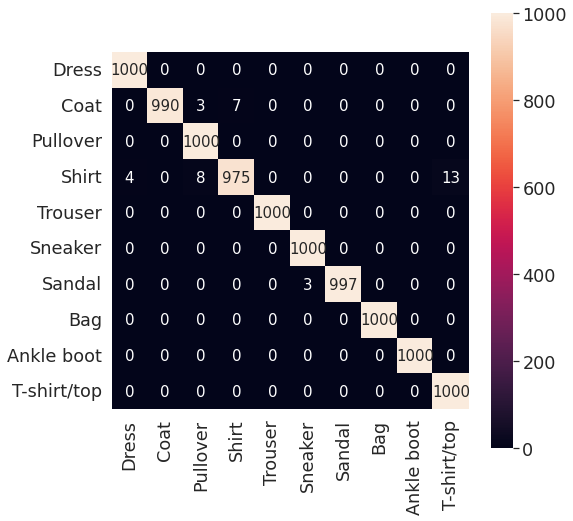

,precision,recall,f1-score,support
Ankle boot,1.000000,1.0000,1.000000,1000.0000
Bag,1.000000,1.0000,1.000000,1000.0000
Coat,1.000000,0.9900,0.994975,1000.0000
Dress,0.996016,1.0000,0.998004,1000.0000
Pullover,0.989120,1.0000,0.994530,1000.0000
Sandal,1.000000,0.9970,0.998498,1000.0000
Shirt,0.992872,0.9750,0.983855,1000.0000
Sneaker,0.997009,1.0000,0.998502,1000.0000
T-shirt/top,0.987167,1.0000,0.993542,1000.0000
Trouser,1.000000,1.0000,1.000000,1000.0000


In [ ]:
print ( "Training Dataset ")
predict_x=model4.predict(X_train) 
Y_pred=np.argmax(predict_x,axis=1)
y_train = []
for x in Y_train:
  y_train.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_train = [labels[ind] for ind in y_train]
print_classification_report(Y_pred, y_train)

Testing Dataset 
              precision    recall  f1-score   support

  Ankle boot       0.91      0.96      0.94       100
         Bag       0.99      0.96      0.97       100
        Coat       0.88      0.86      0.87       100
       Dress       0.90      0.91      0.91       100
    Pullover       0.82      0.84      0.83       100
      Sandal       1.00      0.91      0.95       100
       Shirt       0.82      0.77      0.79       100
     Sneaker       0.89      0.93      0.91       100
 T-shirt/top       0.84      0.87      0.85       100
     Trouser       0.97      0.99      0.98       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



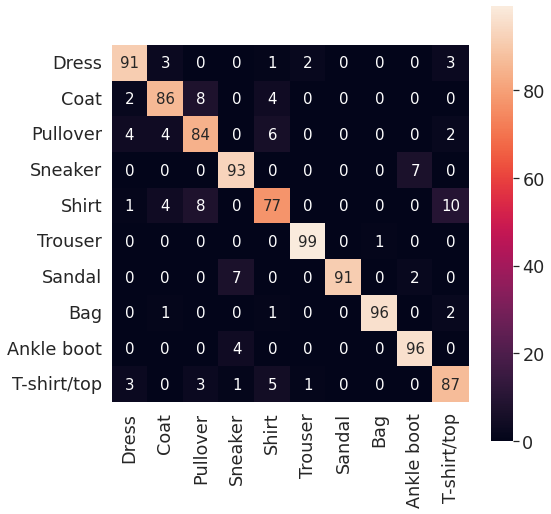

,precision,recall,f1-score,support
Ankle boot,0.914286,0.96,0.936585,100.0
Bag,0.989691,0.96,0.974619,100.0
Coat,0.877551,0.86,0.868687,100.0
Dress,0.900990,0.91,0.905473,100.0
Pullover,0.815534,0.84,0.827586,100.0
Sandal,1.000000,0.91,0.952880,100.0
Shirt,0.819149,0.77,0.793814,100.0
Sneaker,0.885714,0.93,0.907317,100.0
T-shirt/top,0.836538,0.87,0.852941,100.0
Trouser,0.970588,0.99,0.980198,100.0


In [ ]:
print ( "Testing Dataset ")

predict_x=model4.predict(X_test) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in Y_test:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

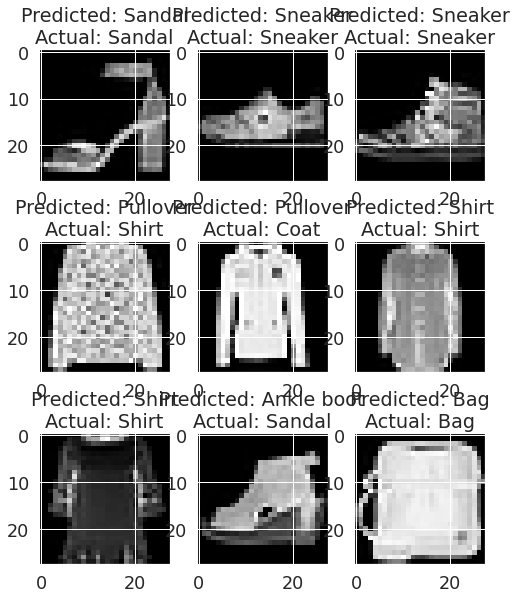

In [ ]:
_, X, _, Y = train_test_split(x_test, Y_test, test_size=10, shuffle=True)
predictions = model4.predict(X)

plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model4.predict(x_test[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = Y_test[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

traslated images

              precision    recall  f1-score   support

  Ankle boot       0.60      0.87      0.71       100
         Bag       0.91      0.86      0.89       100
        Coat       0.76      0.48      0.59       100
       Dress       0.64      0.77      0.70       100
    Pullover       0.56      0.62      0.59       100
      Sandal       0.94      0.85      0.89       100
       Shirt       0.52      0.34      0.41       100
     Sneaker       0.78      0.87      0.82       100
 T-shirt/top       0.64      0.65      0.64       100
     Trouser       0.90      0.88      0.89       100

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.71      1000
weighted avg       0.73      0.72      0.71      1000



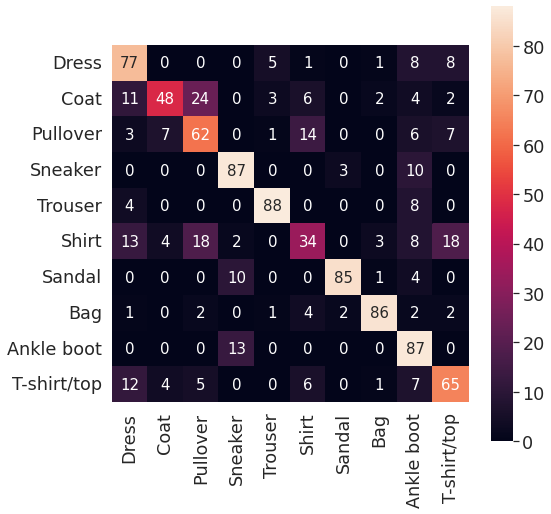

,precision,recall,f1-score,support
Ankle boot,0.604167,0.870,0.713115,100.000
Bag,0.914894,0.860,0.886598,100.000
Coat,0.761905,0.480,0.588957,100.000
Dress,0.636364,0.770,0.696833,100.000
Pullover,0.558559,0.620,0.587678,100.000
Sandal,0.944444,0.850,0.894737,100.000
Shirt,0.523077,0.340,0.412121,100.000
Sneaker,0.776786,0.870,0.820755,100.000
T-shirt/top,0.637255,0.650,0.643564,100.000
Trouser,0.897959,0.880,0.888889,100.000


In [ ]:
predict_x=model4.predict(x_tra) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in y_tra:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

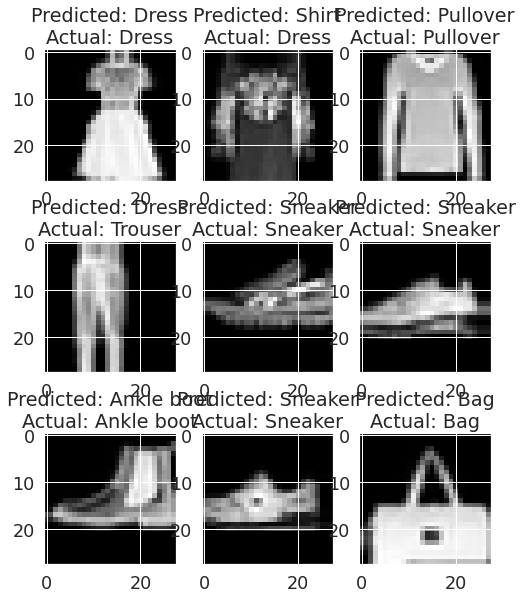

In [ ]:
plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model4.predict(x_tra[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = y_tra[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(x_tra[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

##Model - 5 (With data aug and lr decay)

In [ ]:
# Building a ConvNet
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
    
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_25 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_26 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 64)      

In [ ]:
# reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.1) 

In [ ]:
datagen.fit(x_train)

In [ ]:
# Fit the Model
history = model.fit_generator(datagen.flow(x_train, Y_train, batch_size = 256), epochs = 40, 
                              validation_data = (x_test, Y_test), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // 256
                              # ,callbacks = [reduce_lr]
                              )



Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


39/39 - 4s - loss: 1.2854 - accuracy: 0.5945 - val_loss: 2.7177 - val_accuracy: 0.1000 - 4s/epoch - 106ms/step
Epoch 2/40
39/39 - 3s - loss: 0.8261 - accuracy: 0.7087 - val_loss: 3.1333 - val_accuracy: 0.1000 - 3s/epoch - 70ms/step
Epoch 3/40
39/39 - 3s - loss: 0.7277 - accuracy: 0.7299 - val_loss: 3.0645 - val_accuracy: 0.1000 - 3s/epoch - 69ms/step
Epoch 4/40
39/39 - 3s - loss: 0.6710 - accuracy: 0.7538 - val_loss: 3.2079 - val_accuracy: 0.1000 - 3s/epoch - 70ms/step
Epoch 5/40
39/39 - 3s - loss: 0.6288 - accuracy: 0.7671 - val_loss: 2.5016 - val_accuracy: 0.3080 - 3s/epoch - 70ms/step
Epoch 6/40
39/39 - 3s - loss: 0.5871 - accuracy: 0.7820 - val_loss: 2.3257 - val_accuracy: 0.3160 - 3s/epoch - 70ms/step
Epoch 7/40
39/39 - 3s - loss: 0.5689 - accuracy: 0.7893 - val_loss: 2.5193 - val_accuracy: 0.2570 - 3s/epoch - 69ms/step
Epoch 8/40
39/39 - 3s - loss: 0.5371 - accuracy: 0.8033 - val_loss: 2.5303 - val_accuracy: 0.2910 - 3s/epoch - 69ms/step
Epoch 9/40
39/39 - 3s - loss: 0.5170 - acc

In [ ]:
model.save('/content/gdrive/MyDrive/model5')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model5/assets


Training Dataset 
              precision    recall  f1-score   support

  Ankle boot       0.99      0.96      0.97      1000
         Bag       1.00      0.98      0.99      1000
        Coat       0.82      0.85      0.83      1000
       Dress       0.69      0.98      0.81      1000
    Pullover       0.86      0.89      0.87      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.79      0.69      0.74      1000
     Sneaker       0.96      0.99      0.97      1000
 T-shirt/top       0.91      0.71      0.80      1000
     Trouser       1.00      0.87      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



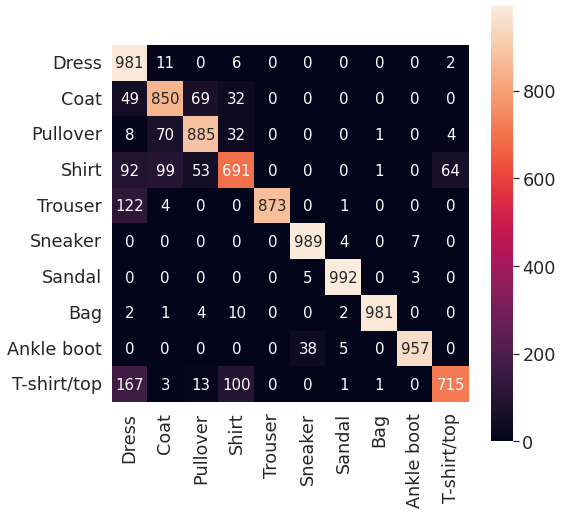

,precision,recall,f1-score,support
Ankle boot,0.989659,0.9570,0.973055,1000.0000
Bag,0.996951,0.9810,0.988911,1000.0000
Coat,0.818882,0.8500,0.834151,1000.0000
Dress,0.690359,0.9810,0.810409,1000.0000
Pullover,0.864258,0.8850,0.874506,1000.0000
Sandal,0.987065,0.9920,0.989526,1000.0000
Shirt,0.793341,0.6910,0.738642,1000.0000
Sneaker,0.958333,0.9890,0.973425,1000.0000
T-shirt/top,0.910828,0.7150,0.801120,1000.0000
Trouser,1.000000,0.8730,0.932194,1000.0000


In [ ]:
print ( "Training Dataset ")
predict_x=model.predict(X_train) 
Y_pred=np.argmax(predict_x,axis=1)
y_train = []
for x in Y_train:
  y_train.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_train = [labels[ind] for ind in y_train]
print_classification_report(Y_pred, y_train)

Testing Dataset 
              precision    recall  f1-score   support

  Ankle boot       0.98      0.93      0.95       100
         Bag       0.99      0.98      0.98       100
        Coat       0.79      0.86      0.82       100
       Dress       0.71      0.98      0.82       100
    Pullover       0.86      0.78      0.82       100
      Sandal       0.97      0.95      0.96       100
       Shirt       0.75      0.71      0.73       100
     Sneaker       0.90      0.96      0.93       100
 T-shirt/top       0.95      0.72      0.82       100
     Trouser       0.99      0.90      0.94       100

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



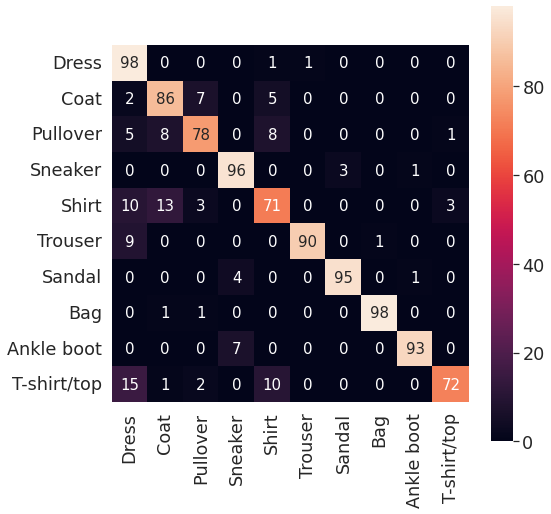

,precision,recall,f1-score,support
Ankle boot,0.978947,0.930,0.953846,100.000
Bag,0.989899,0.980,0.984925,100.000
Coat,0.788991,0.860,0.822967,100.000
Dress,0.705036,0.980,0.820084,100.000
Pullover,0.857143,0.780,0.816754,100.000
Sandal,0.969388,0.950,0.959596,100.000
Shirt,0.747368,0.710,0.728205,100.000
Sneaker,0.897196,0.960,0.927536,100.000
T-shirt/top,0.947368,0.720,0.818182,100.000
Trouser,0.989011,0.900,0.942408,100.000


In [ ]:
print ( "Testing Dataset ")

predict_x=model.predict(X_test) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in Y_test:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

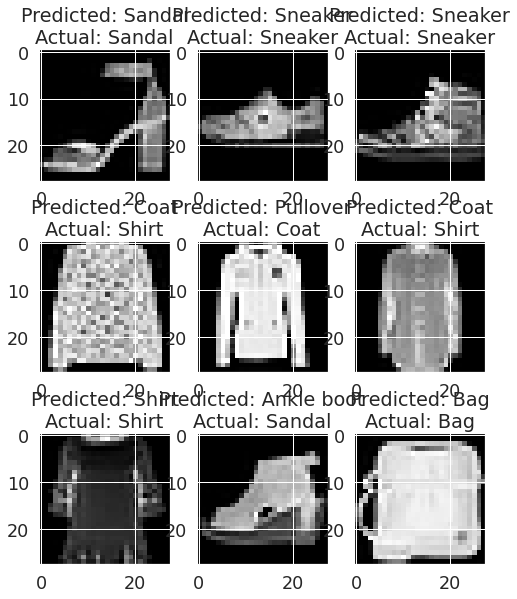

In [ ]:
_, X, _, Y = train_test_split(x_test, Y_test, test_size=10, shuffle=True)
predictions = model.predict(X)

plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model.predict(x_test[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = Y_test[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

traslated images

              precision    recall  f1-score   support

  Ankle boot       0.98      0.94      0.96       100
         Bag       0.99      0.96      0.97       100
        Coat       0.73      0.79      0.76       100
       Dress       0.70      0.95      0.81       100
    Pullover       0.71      0.85      0.77       100
      Sandal       0.99      0.91      0.95       100
       Shirt       0.72      0.47      0.57       100
     Sneaker       0.88      0.98      0.92       100
 T-shirt/top       0.87      0.69      0.77       100
     Trouser       0.99      0.94      0.96       100

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.84      1000
weighted avg       0.86      0.85      0.84      1000



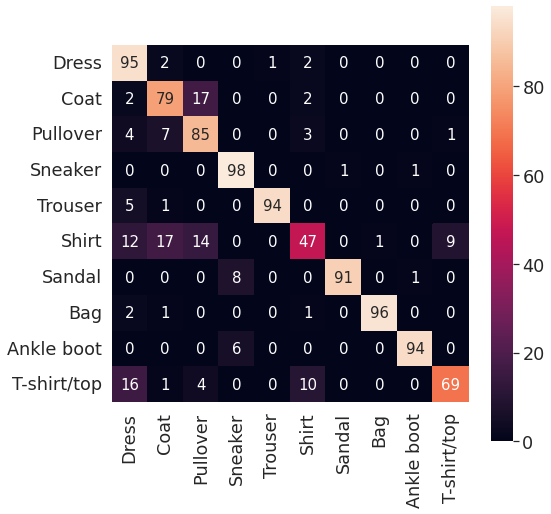

,precision,recall,f1-score,support
Ankle boot,0.979167,0.940,0.959184,100.000
Bag,0.989691,0.960,0.974619,100.000
Coat,0.731481,0.790,0.759615,100.000
Dress,0.698529,0.950,0.805085,100.000
Pullover,0.708333,0.850,0.772727,100.000
Sandal,0.989130,0.910,0.947917,100.000
Shirt,0.723077,0.470,0.569697,100.000
Sneaker,0.875000,0.980,0.924528,100.000
T-shirt/top,0.873418,0.690,0.770950,100.000
Trouser,0.989474,0.940,0.964103,100.000


In [ ]:
predict_x=model.predict(x_tra) 
Y_pred=np.argmax(predict_x,axis=1)
y_test = []
for x in y_tra:
  y_test.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]

print_classification_report(Y_pred, y_test)

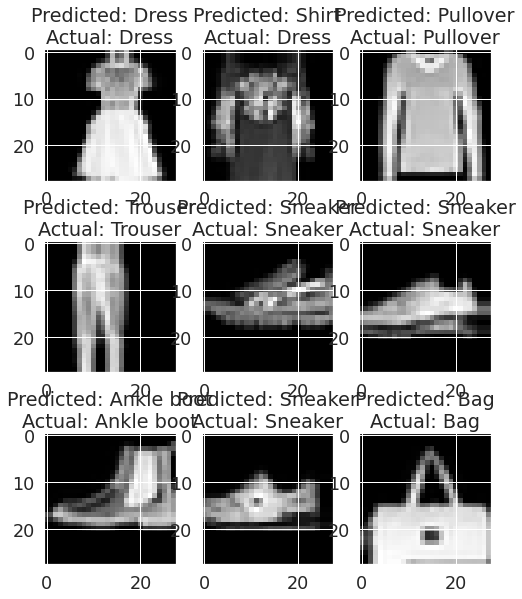

In [ ]:
plt.figure(figsize=(8,10))
for i in range(9):
    # define subplot
    value = model.predict(x_tra[i].reshape(1, 28, 28))
    predicted = value.argmax()
    actual = y_tra[i].argmax()
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.title("Predicted: " + labels[predicted] + "\nActual: " + labels[actual])
    plt.imshow(x_tra[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Results


Model | Training Acc | Testing Acc | Overlapping classes
--- | ---  | --- | ---
FFNN 1 | 94 | 88 | SHirt- Tshirts, coat-pullover, coat - shirt
FFNN 2 | 93 | 86 | SHirt- Tshirts, coat-pullover, coat - shirt
Simple CNN | 99.02 | 88.4 | SHirt- Tshirts, coat-pullover, coat - shirt
CNN2 | 98 | 90.3 | SHirt- Tshirts, coat-pullover, coat - shirt



Confusion Matrices of Model 3 and Model 4

Model 3 : 

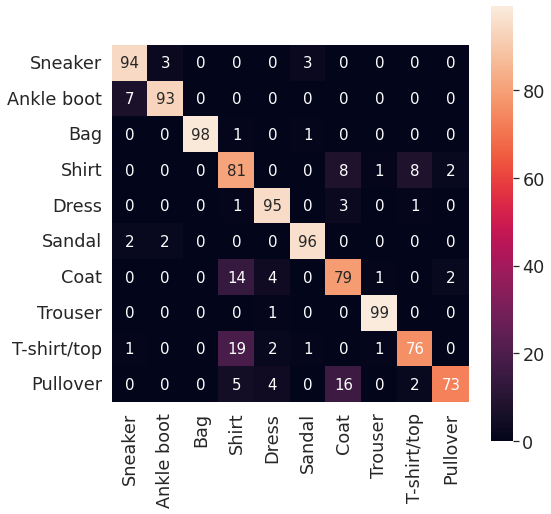Model 4 : 
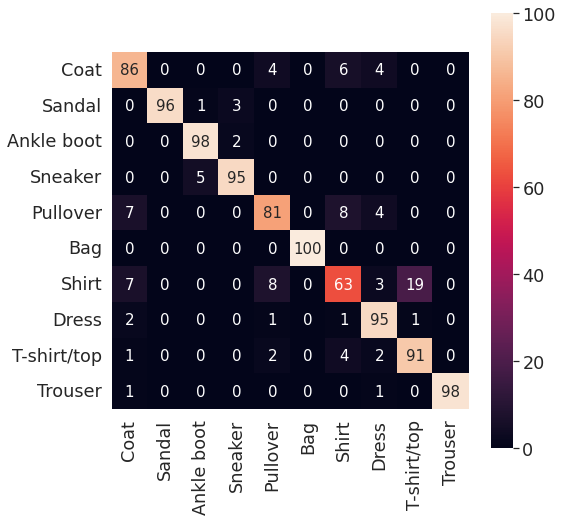

As it can be seen, although Model 4 performs over all better than model 3, but in some classes like shirt, trousers : the accuracies are better in Model 4. Hence, we will try ensembling these models by model averaging method and get the predictions.

## Ensembling Techniques

In [ ]:
from tensorflow import keras

cnn1 = keras.models.load_model('/content/gdrive/MyDrive/model3')
cnn2 = keras.models.load_model('/content/gdrive/MyDrive/model4')

In [ ]:
models = [cnn1, cnn2]

model_predictions = []
for model in models:
  pred = model.predict(X_test) 
  model_predictions.append(pred)

predictions = np.mean(model_predictions, axis=0)

In [ ]:
Y_pred=np.argmax(predictions,axis=1)
Y_pred = [labels[ind] for ind in Y_pred]


              precision    recall  f1-score   support

  Ankle boot       0.95      0.98      0.97       100
         Bag       1.00      0.99      0.99       100
        Coat       0.86      0.89      0.87       100
       Dress       0.87      0.95      0.91       100
    Pullover       0.88      0.82      0.85       100
      Sandal       1.00      0.96      0.98       100
       Shirt       0.82      0.72      0.77       100
     Sneaker       0.95      0.96      0.96       100
 T-shirt/top       0.86      0.93      0.89       100
     Trouser       0.98      0.97      0.97       100

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



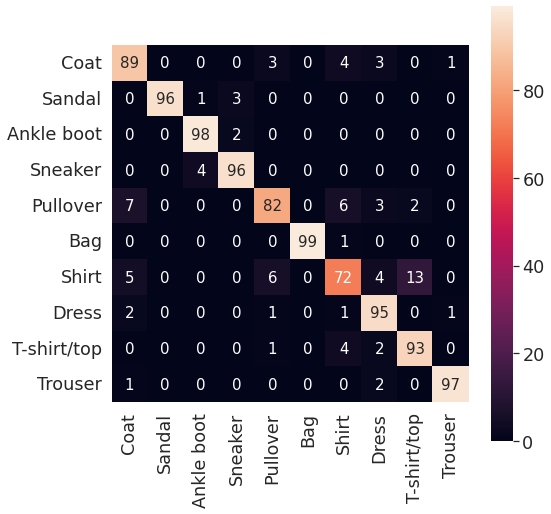

,precision,recall,f1-score,support
Ankle boot,0.951456,0.980,0.965517,100.000
Bag,1.000000,0.990,0.994975,100.000
Coat,0.855769,0.890,0.872549,100.000
Dress,0.871560,0.950,0.909091,100.000
Pullover,0.881720,0.820,0.849741,100.000
Sandal,1.000000,0.960,0.979592,100.000
Shirt,0.818182,0.720,0.765957,100.000
Sneaker,0.950495,0.960,0.955224,100.000
T-shirt/top,0.861111,0.930,0.894231,100.000
Trouser,0.979798,0.970,0.974874,100.000


In [ ]:
print_classification_report(Y_pred, y_test)

## Inferences and Conclusion : State all the key observations and conclusion

**Model 1 :**

Test - 0.87

Translated - 0.61

**Model 2 :** 

Test - 0.87

Translated - 0.56

**Model 3 :**  

Test - 0.89

Translated - 0.66

**Model 4 :**   

Test - 0.90

Translated - 0.72

**Ensemble model (model 3 + model 4) :**

Test - 0.92

**Model  5 :**

Test - 0.90

Translated - 0.85


